## Measurement confusion

The scientific community is inconsistent (at best) when discussing absorption and absorbance. 

**Absorbance**

Spectroscopy texts consider only absorbance, aside from reflectance and transmittance. IUPAC$^1$ defines the quantity as "[the] Logarithm of the ratio of incident to transmitted radiant power through a sample."

$$A = -log_{10} \frac{I}{I_o}$$

Spectophotometry uses the same definition, but generally talks about this in terms of transmission (defined as $T = \frac{I}{I_o}$). 

**Optical density** is commonly used in place of absorbance - IUPAC defines them as synonymous, but discourages the use of OD.

<!--![image.png](attachment:image.png)-->


**Absorbtion**

Optical physics texts take a more holistic view, describing absorbtion in concert with reflection and transmission:

$$A = 1 - T - R$$

While these are both dimensionless quantities, 

[1] https://doi.org/10.1351/goldbook.O04306

## Setup, File I/O

importing some libraries to assist with linear algebra, file i/o, and plotting. *with* loops read in the optical constants (PMMA and Si) as a *dictionary* and save them to an *array*. **TO DO**: SiC, SiO<sub>2</sub>, Au

*csv input is natively [nm], [n], [k], can use nm2wavenumber() to accept frequency


In [424]:
from __future__ import division, print_function, absolute_import
from tmm import (coh_tmm, unpolarized_RT, ellips, position_resolved, find_in_structure_with_inf)
from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import csv
import time
%matplotlib inline

def nm2wavenumber(lambda_nm):
    omega = (10**7)/lambda_nm
    return ["%.0f" % w for w in omega]

try:
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color
    colors_were_imported = True
except ImportError:
    colors_were_imported = False

# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = pi/180

#read in PMMA optical constants from .csv file [nm, n, k]
arrayPMMA, arraySi, arraySiO2 = [], [], []

with open('PMMAc.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        readrow = [float(row['nm']), float(row['n']) + float(row['k'])*1j]
        arrayPMMA.append(readrow)
        
with open('PSic.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        readrow = [float(row['nm']), float(row['n']) + float(row['k'])*1j]
        arraySi.append(readrow)

## PMMA suspended in air
Here we plot the transmitted intensity versus wavelength through single-layer PMMA films. Air is on both sides of the film, and the light is normally incident.


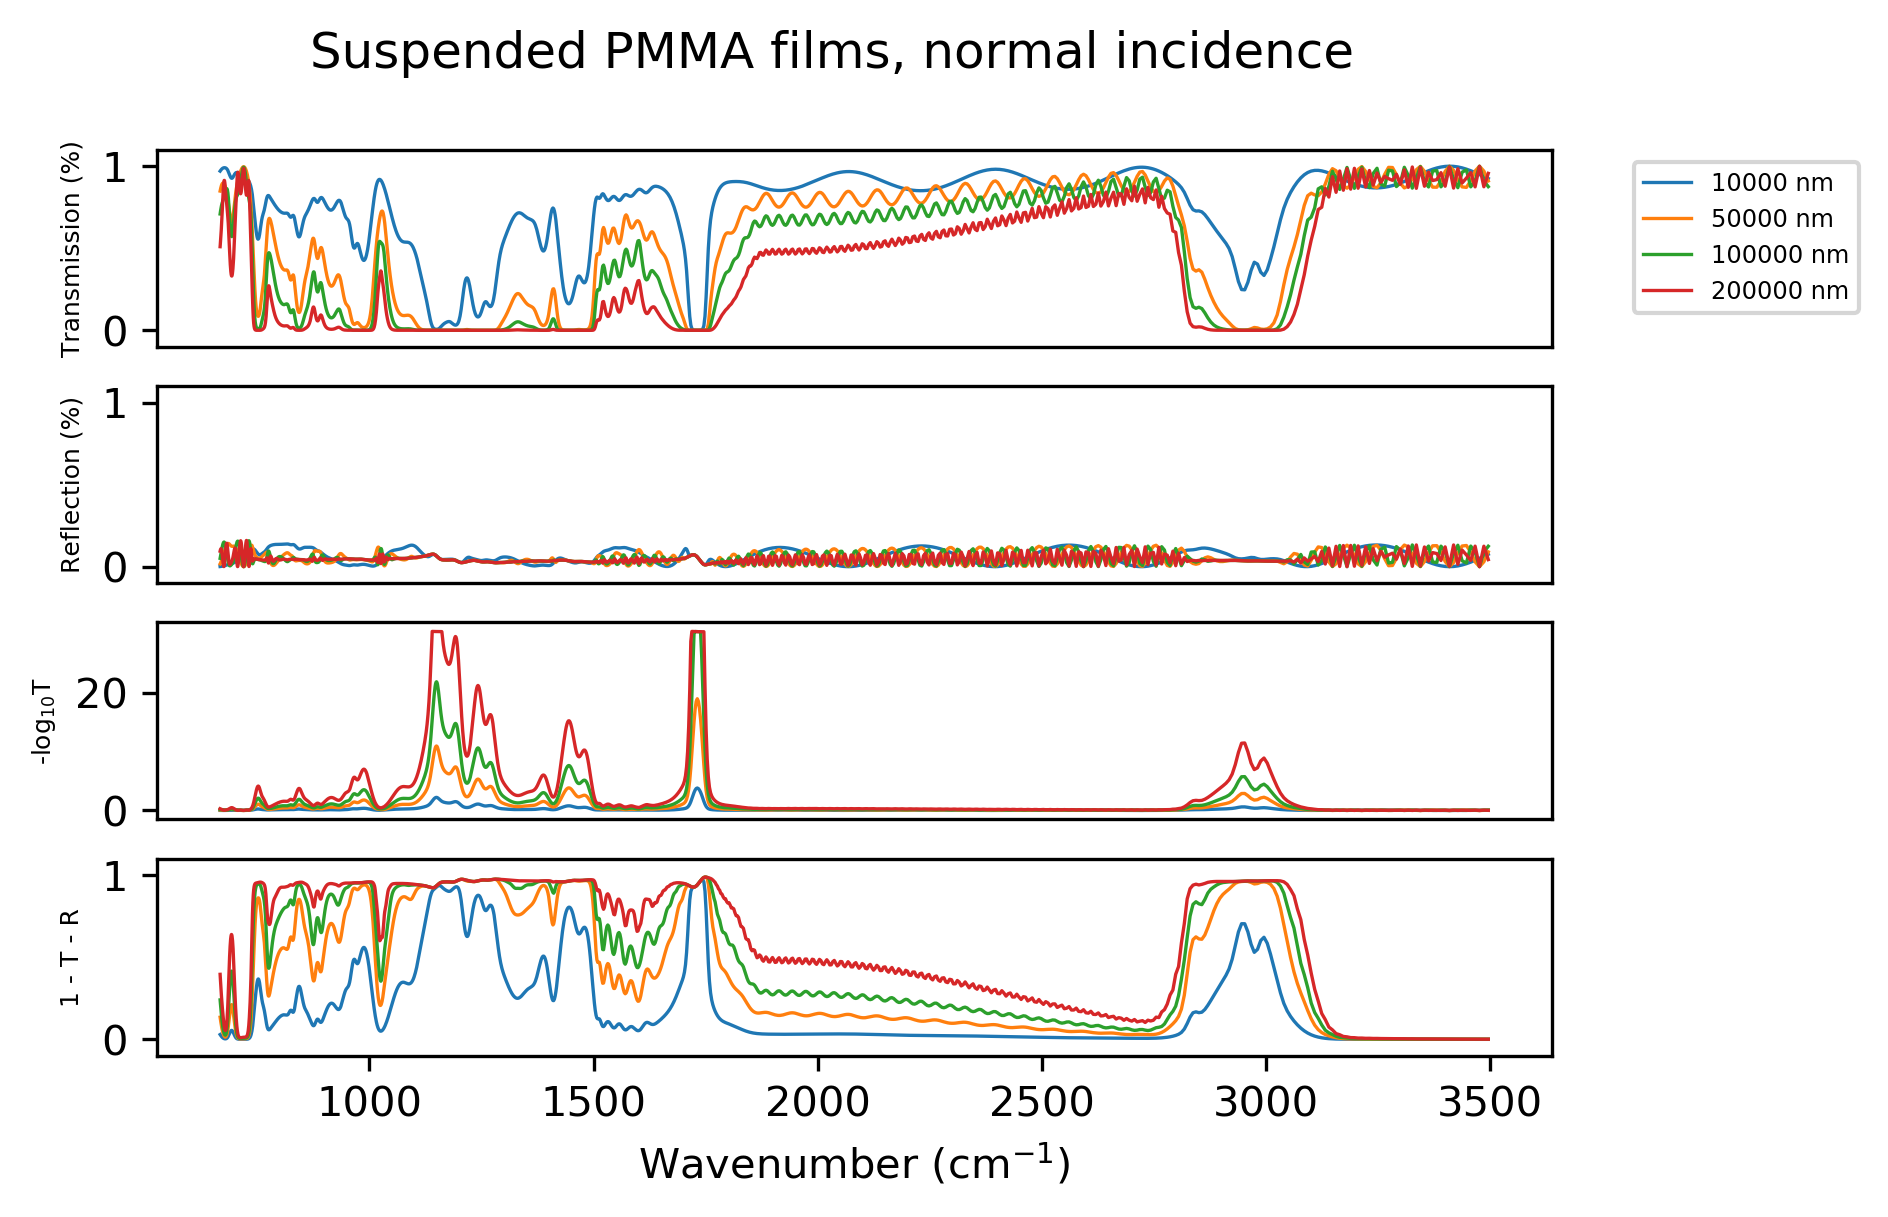

In [435]:
start_time = time.time()

# sets is the list of thicknesses to calculate
set1 = [100,500,1000,2000]
sets = [10000,50000,100000,200000]

freq_tick_locations = np.array([3333, 5000, 10000])
lambda_tick_locations = np.array([4000,7000,10000])

fig = plt.figure(dpi = 300)
fig.suptitle('Suspended PMMA films, normal incidence')

Tx1, Rx1, NAx1, Ax1 = fig.add_subplot(411), fig.add_subplot(412), fig.add_subplot(413), fig.add_subplot(414)

material_nk_data = array(arrayPMMA)
material_nk_fn = interp1d(material_nk_data[:,0].real,
                          material_nk_data[:,1], kind='quadratic')

lambda_list = linspace(2860,15000,1500) #in nm
omega_list = (10**7)/lambda_list
Tplot, Rplot, Aplot, NAplot = [], [], [], []

for thickness in sets:
    d_list = [inf,thickness,inf] #in nm

    T_list, A_list, R_list, NA_list = [], [], [], []
    for lambda_vac in lambda_list:
        n_list = [1, material_nk_fn(lambda_vac), 1]
        coherent = coh_tmm('s',n_list,d_list,0,lambda_vac)
        T_list.append(coherent['T'])
        R_list.append(coherent['R'])
        A_list.append((1-coherent['T'])-(coherent['R']))
        NA_list.append(-np.log10(coherent['T']))
        
    Tplot.append(T_list)
    Aplot.append(A_list)
    Rplot.append(R_list)
    NAplot.append(NA_list)
    
    Tx1.plot(omega_list,T_list, linewidth = 0.8, label = str(thickness)+' nm')
    Ax1.plot(omega_list,A_list, linewidth = 0.8, label = str(thickness)+' nm')
    Rx1.plot(omega_list,R_list, linewidth = 0.8, label = str(thickness)+' nm')
    NAx1.plot(omega_list,NA_list, linewidth = 0.8, label = str(thickness)+' nm')

#everything below is plot formatting 
    
Tx1.set_ylabel('Transmission (%)', fontsize = 6)
Tx1.set_ylim(-0.1,1.1)
Tx1.xaxis.set_visible(False)

Rx1.set_ylabel('Reflection (%)', fontsize = 6)
Rx1.set_ylim(-0.1,1.1)
Rx1.xaxis.set_visible(False)

Ax1.set_xlabel('Wavenumber (cm$^{-1}$)')
Ax1.set_ylabel('1 - T - R', fontsize = 6)
Ax1.set_ylim(-0.1,1.1)

NAx1.set_ylabel('-log$_{10}$T', fontsize = 6)
#NAx1.set_ylim(-0.1,1.1)
NAx1.xaxis.set_visible(False)

Tx1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-small')
plt.savefig('PMMAfilms_omega')
plt.show()

#print("runtime: %.5s seconds"% (time.time() - start_time))


Note the difference between absorption ($-log_{10}T$) and absorbance ($1-T-R$). Look at absorbance and absorption on the same plot

## Thin film on a thick absorbing layer

Here we model a thin non-absorbing layer, on top of a thick absorbing layer, with air on both sides. Plotting reflected intensity versus wavenumber, at two different incident angles.

to do: modify to use in IR (discontinuous index)

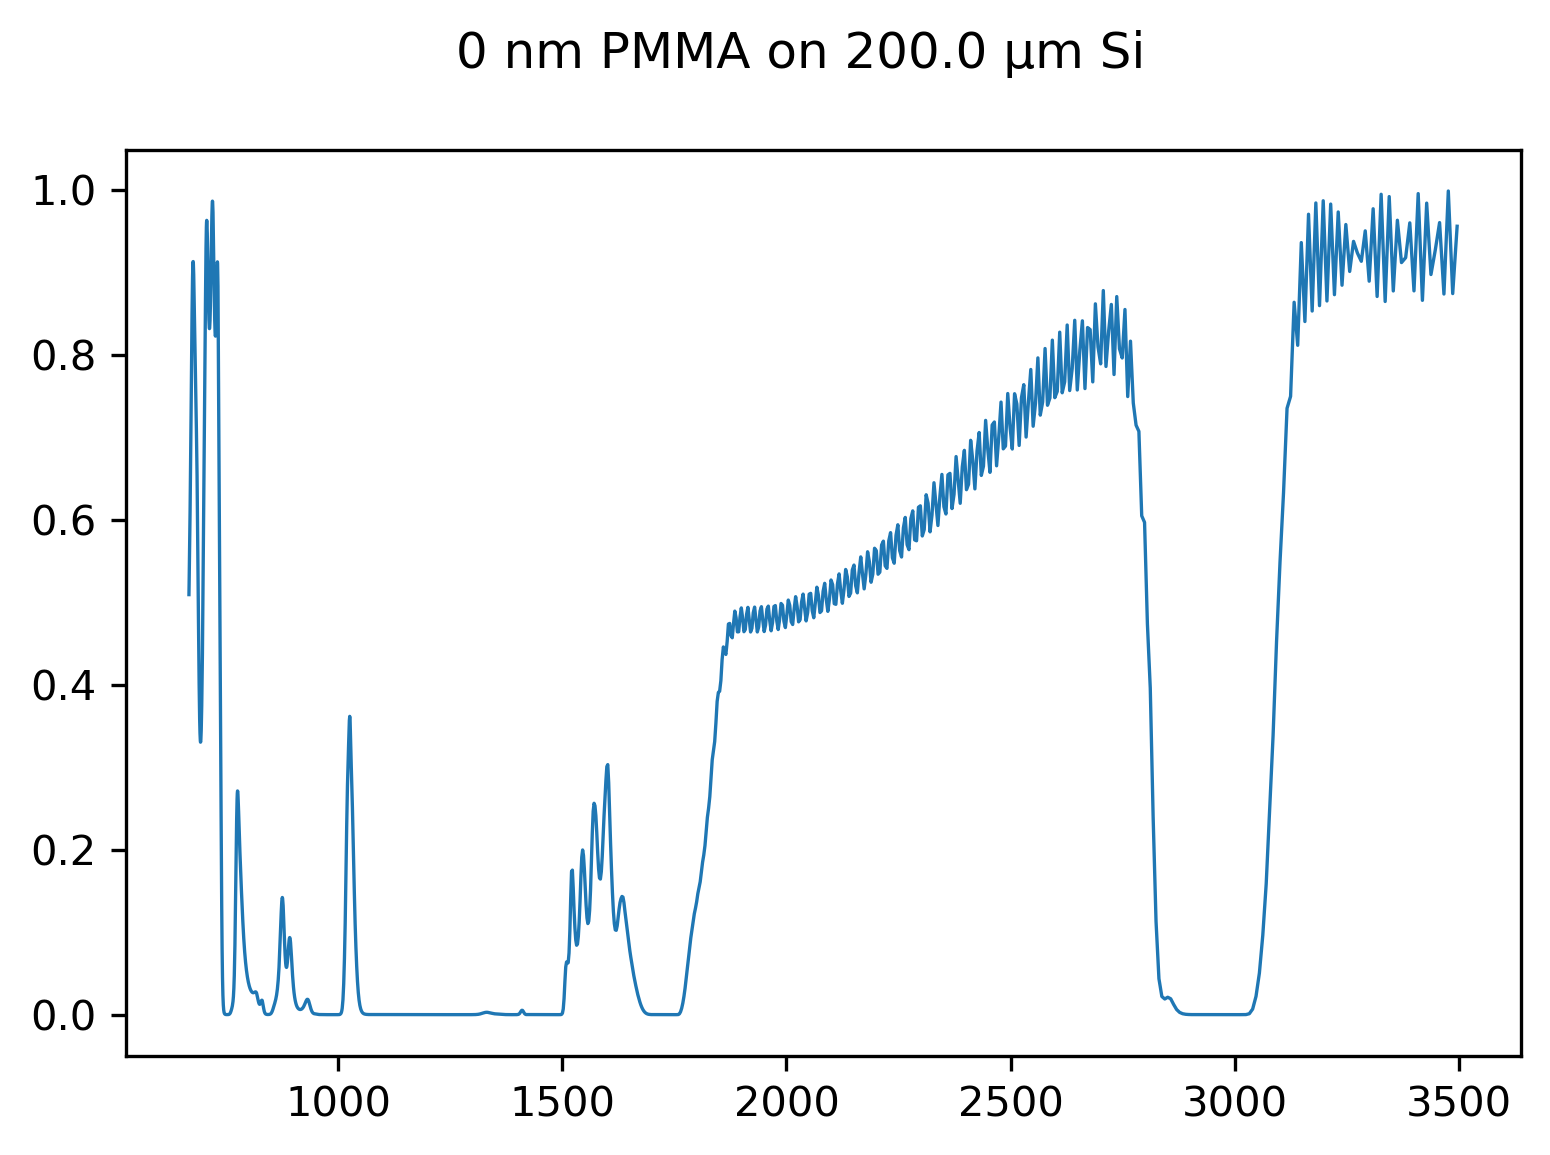

In [358]:
## sets is the list of thicknesses to calculate
sets = [100]
thicknessPMMA = 0
thicknessSi = 200000
fig = plt.figure(dpi = 300)
fig.suptitle(str(thicknessPMMA)+' nm PMMA on '+str(thicknessSi/1000)+' μm Si')
Tx1 = fig.add_subplot(111)

PMMA_nk_data = array(arrayPMMA)
Si_nk_data = array(arraySi)

#interpolated n and k from csv files
PMMA_nk_fn = interp1d(PMMA_nk_data[:,0].real, PMMA_nk_data[:,1], kind='quadratic')
Si_nk_fn = interp1d(Si_nk_data[:,0].real, Si_nk_data[:,1], kind='quadratic')

#layer thicknesses
d_list = [inf, thicknessPMMA, thicknessSi, inf] #in nm

#setup lambda, omega, T (empty)
lambda_list = linspace(2860,15000,1500) #in nm
omega_list = (10**7)/lambda_list #in 1/cm
T_list = []

for thickness in sets:

    for lambda_vac in lambda_list:
        n_list = [1, PMMA_nk_fn(lambda_vac), PMMA_nk_fn(lambda_vac), 1]
        T_list.append(coh_tmm('s',n_list,d_list,0,lambda_vac)['T'])
    Tx1.plot(omega_list,T_list, linewidth = 0.8)


plt.show()

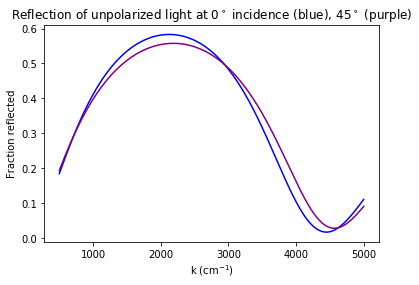

In [298]:
# list of layer thicknesses in nm
d_list = [inf,100,300,inf]
# list of refractive indices
n_list = [1,2.2,3.3+0.3j,1]
# list of wavenumbers to plot in nm^-1
ks=linspace(0.00005,.0005,num=400)
# initialize lists of y-values to plot
Rnorm=[] 
R45=[]
for k in ks:
    # For normal incidence, s and p polarizations are identical.
    # I arbitrarily decided to use 's'.
    Rnorm.append(coh_tmm('s',n_list, d_list, 0, 1/k)['R'])
    R45.append(unpolarized_RT(n_list, d_list, 45*degree, 1/k)['R'])
kcm = ks * 1e7 #ks in cm^-1 rather than nm^-1
plt.figure()
plt.plot(kcm,Rnorm,'blue',kcm,R45,'purple')
plt.xlabel('k (cm$^{-1}$)')
plt.ylabel('Fraction reflected')
plt.title('Reflection of unpolarized light at 0$^\circ$ incidence (blue), '
            '45$^\circ$ (purple)');


## Ellipsometric modeling

Here, a calculation of the psi and Delta parameters measured in ellipsometry. This reproduces Fig. 1.14 in Handbook of Ellipsometry by Tompkins, 2005 (below).

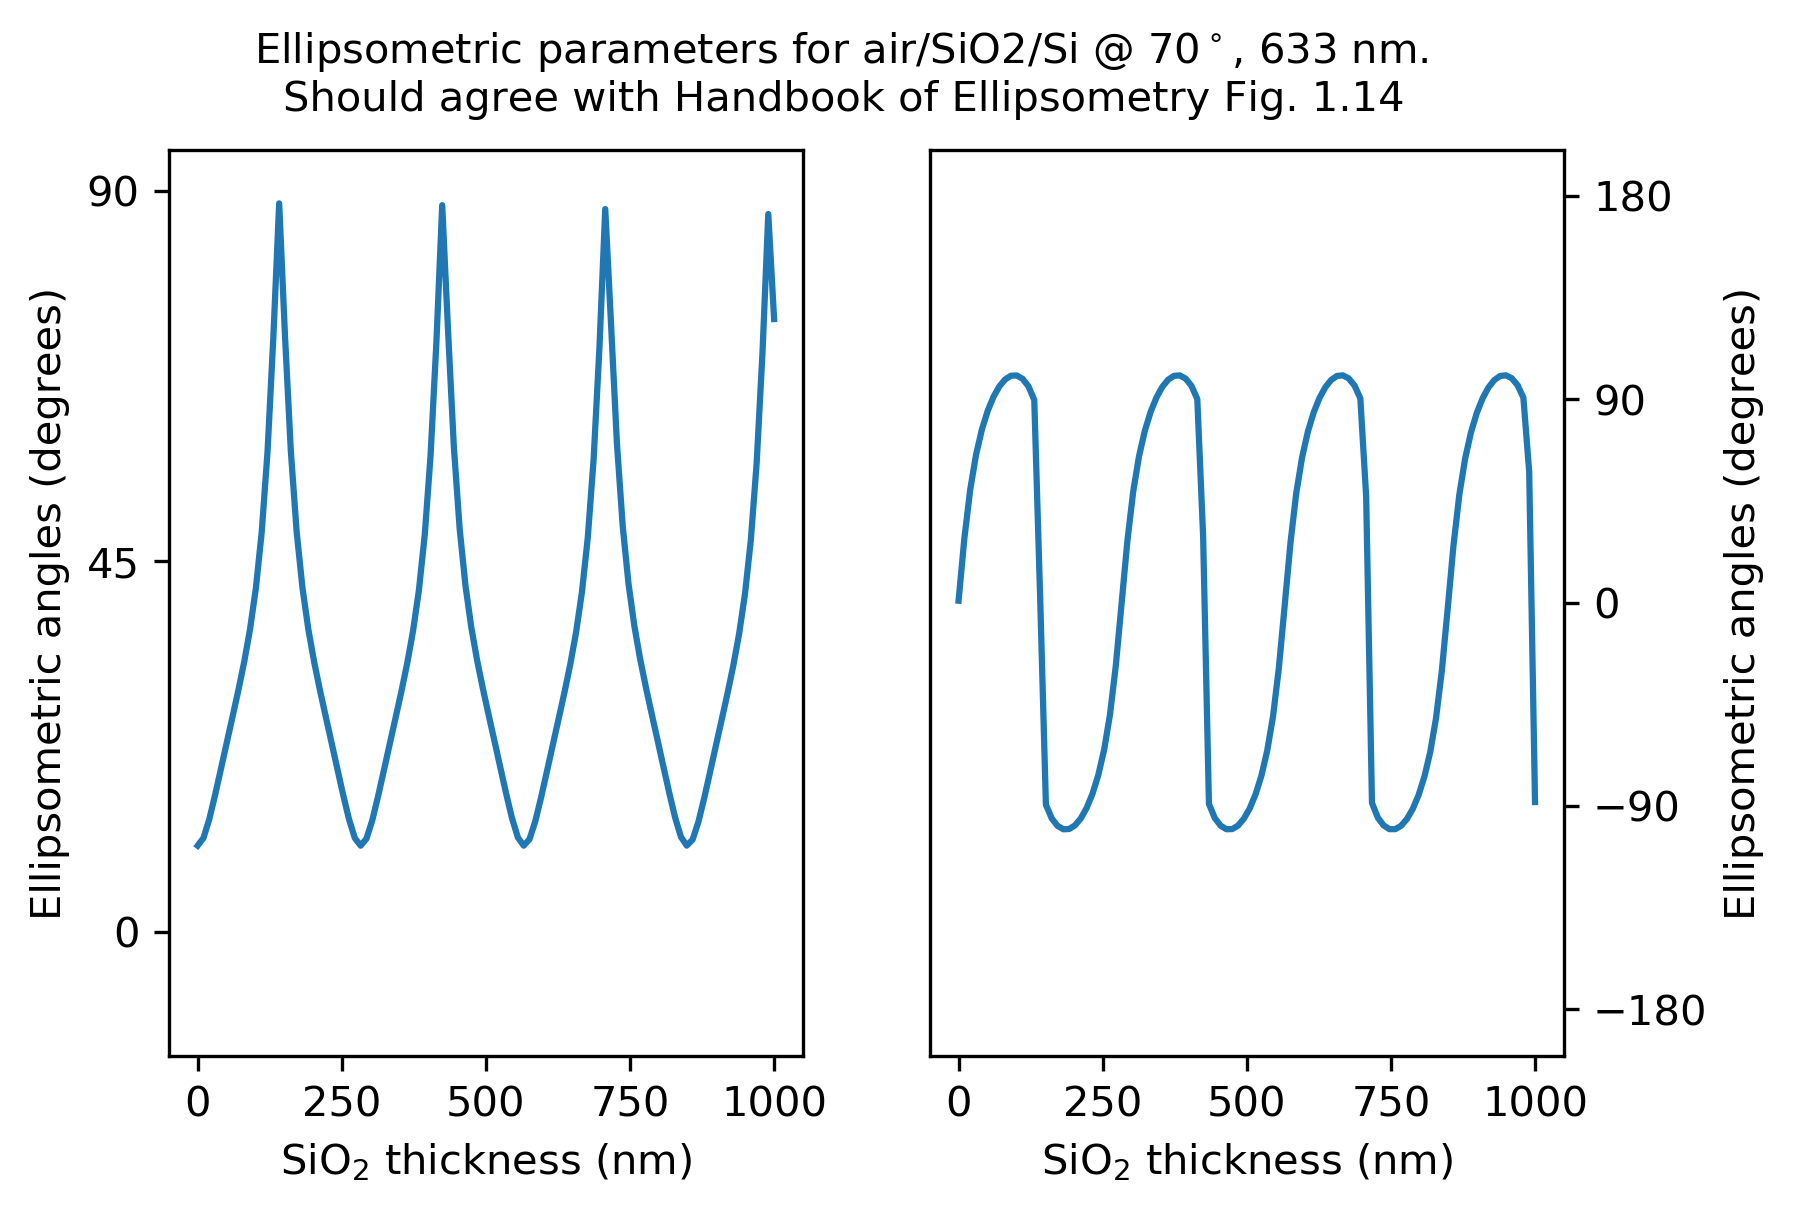

In [245]:

n_list=[1,1.46,3.87+0.02j]
ds=linspace(0,1000,num=100) #in nm
psis=[]
Deltas=[]
for d in ds:
    e_data=ellips(n_list, [inf,d,inf], 70*degree, 633) #in nm
    psis.append(e_data['psi']/degree) # angle in degrees
    Deltas.append(e_data['Delta']/degree) # angle in degrees

fig = plt.figure(dpi = 300)
Del = fig.add_subplot(121)
Psi = fig.add_subplot(122)

Del.plot(ds,psis)
Del.set_xlabel('SiO$_2$ thickness (nm)')
Del.set_ylabel('Ellipsometric angles (degrees)')
Del.set_ylim(-15,95)
Del.set_yticks([0,45,90])

Psi.plot(ds,Deltas)
Psi.yaxis.set_label_position("right")
Psi.yaxis.tick_right()
Psi.set_ylim(-200.5,200.5)
Psi.set_yticks([-180,-90,0,90,180])
Psi.set_xlabel('SiO$_2$ thickness (nm)')
Psi.set_ylabel('Ellipsometric angles (degrees)')
fig.suptitle('Ellipsometric parameters for air/SiO2/Si @ 70$^\circ$, 633 nm. \n'
        'Should agree with Handbook of Ellipsometry Fig. 1.14', fontsize = 10);

## Handbook of Ellipsometry, fig 1.14
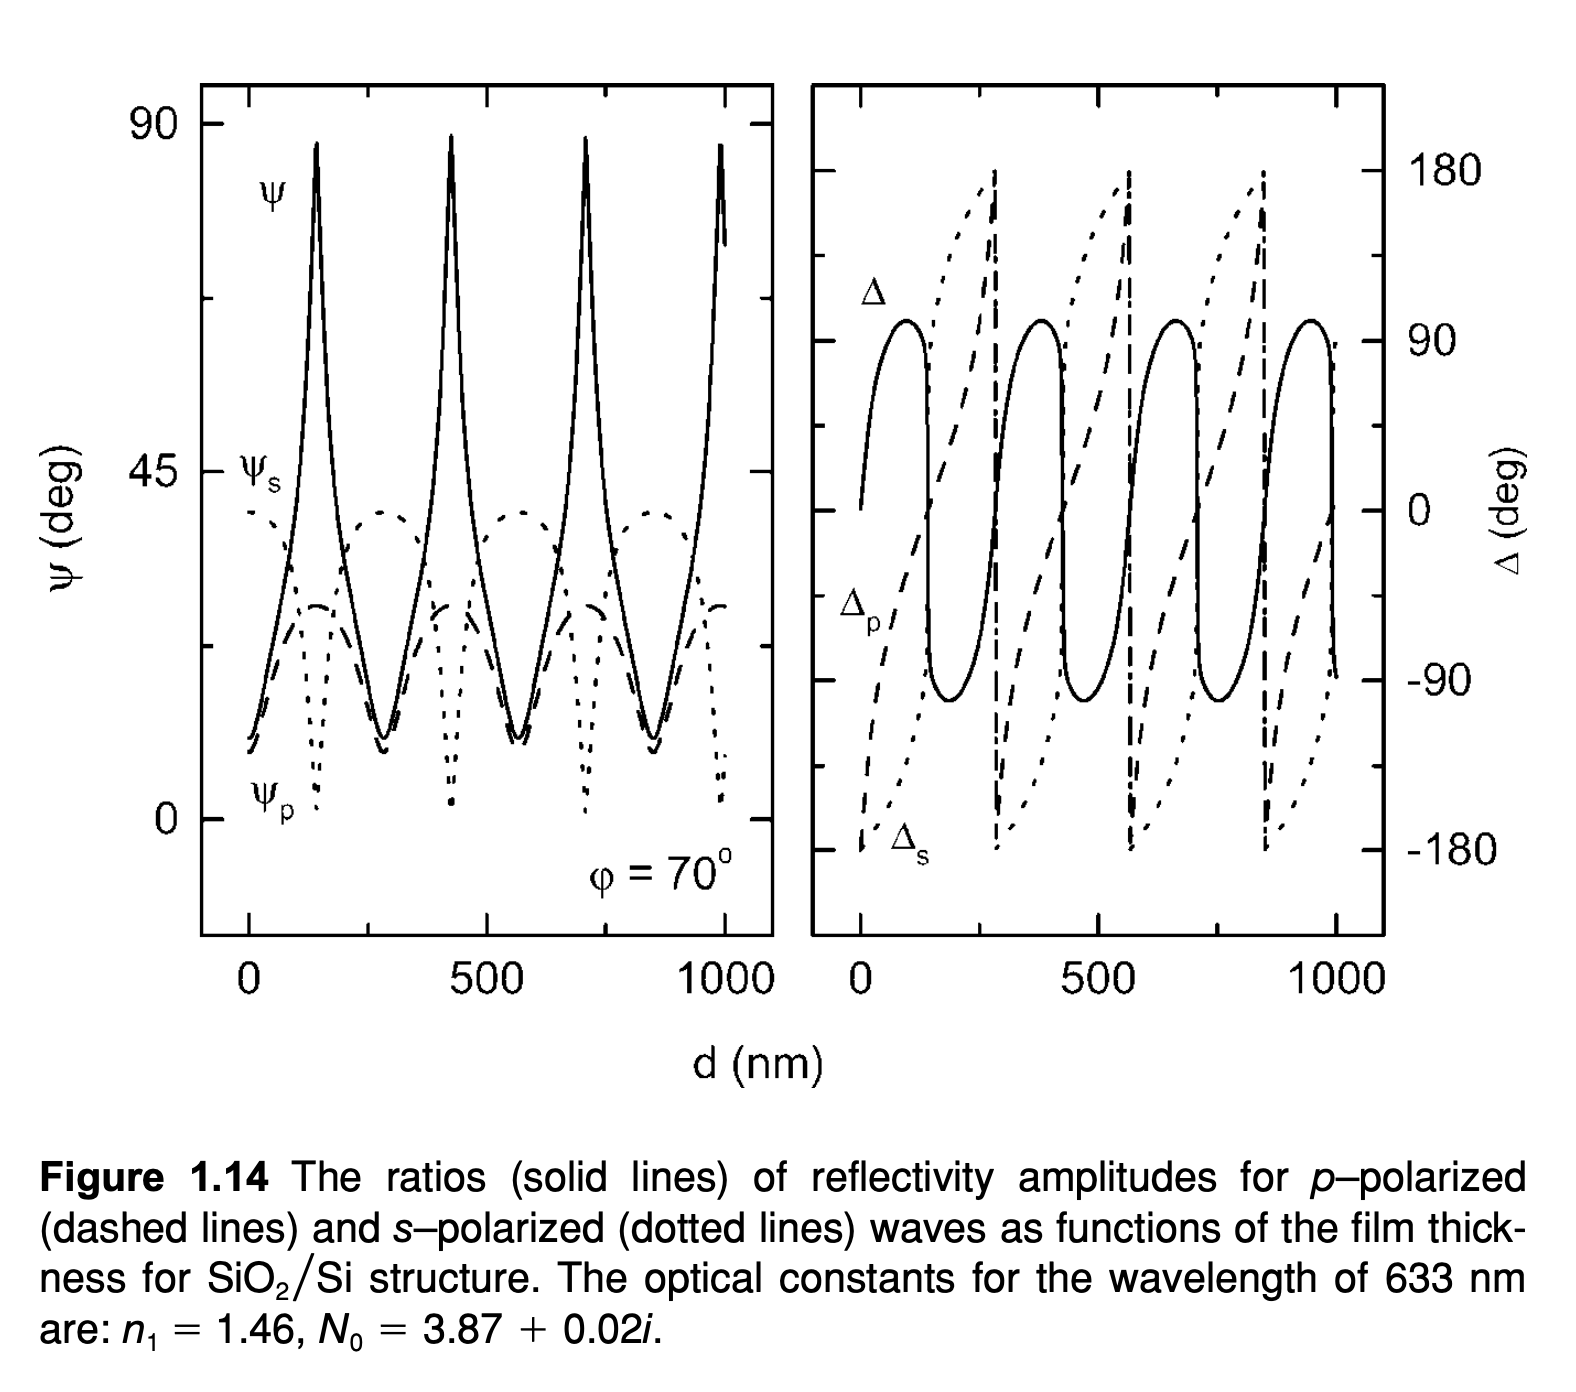

## Absorption and Poynting vector
Plot absorption and Poynting vector as a function of depth.

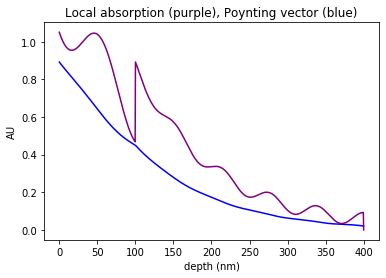

In [7]:
d_list = [inf, 100, 300, inf] #in nm
n_list = [1, 2.2+0.2j, 3.3+0.3j, 1]
th_0=pi/4
lam_vac=400
pol='p'
coh_tmm_data = coh_tmm(pol,n_list,d_list,th_0,lam_vac)

ds = linspace(0,400,num=1000) #position in structure
poyn=[]
absor=[]
for d in ds:
    layer, d_in_layer = find_in_structure_with_inf(d_list,d)
    data=position_resolved(layer,d_in_layer,coh_tmm_data)
    poyn.append(data['poyn'])
    absor.append(data['absor'])
# convert data to numpy arrays for easy scaling in the plot
poyn = array(poyn)
absor = array(absor)
plt.figure()
plt.plot(ds,poyn,'blue',ds,200*absor,'purple')
plt.xlabel('depth (nm)')
plt.ylabel('AU')
plt.title('Local absorption (purple), Poynting vector (blue)');

## Visible effects: Can we predict the color of a thin SiO$_2$ /Si stack?



Saving plot temp_plot.png
Saving plot temp_plot.png


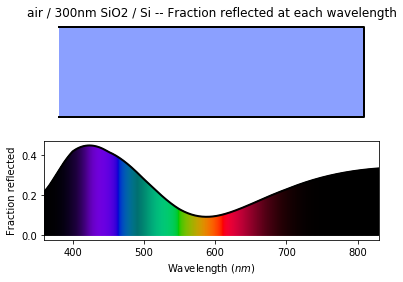

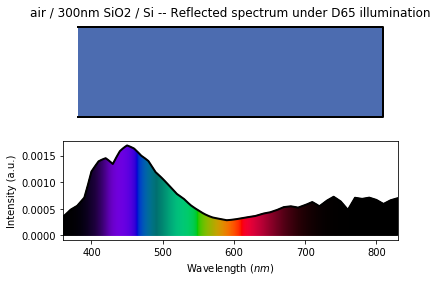

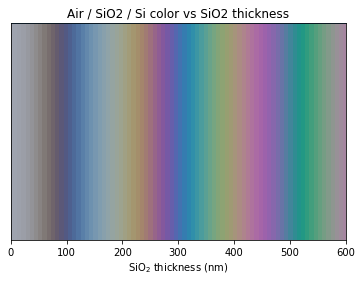

In [437]:
if not colors_were_imported:
    print('Colorpy not detected')
else:
    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1

    n_fn_list = [air_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0

    # Print the colors, and show plots, for the special case of 300nm-thick SiO2
    d_list = [inf, 300, inf]
    reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    illuminant = colorpy.illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    #print('air / 300nm SiO2 / Si --- rgb =', color_dict['rgb'], ', xyY =', color_dict['xyY'])
    plt.figure()
    color.plot_reflectances(reflectances,
                        title='air / 300nm SiO2 / Si -- '
                              'Fraction reflected at each wavelength')
    plt.figure()
    color.plot_spectrum(spectrum,
                        title='air / 300nm SiO2 / Si -- '
                              'Reflected spectrum under D65 illumination')

    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_SiO2_thickness = 600
    SiO2_thickness_list = linspace(0,max_SiO2_thickness,num=80)
    irgb_list = []
    for SiO2_d in SiO2_thickness_list:
        d_list = [inf, SiO2_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    #print('Making color vs SiO2 thickness graph. Compare to (for example)')
    #print('http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm')
    plt.figure()
    plt.plot([0,max_SiO2_thickness],[1,1])
    plt.xlim(0,max_SiO2_thickness)
    plt.ylim(0,1)
    plt.xlabel('SiO$_2$ thickness (nm)')
    plt.yticks([])
    plt.title('Air / SiO2 / Si color vs SiO2 thickness')
    for i in range(len(SiO2_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (SiO2_thickness_list[i] + SiO2_thickness_list[i-1]) / 2
        if i == len(SiO2_thickness_list) - 1:
            x1 = max_SiO2_thickness
        else:
            x1 = (SiO2_thickness_list[i] + SiO2_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

## Sample 6
An example reflection plot with a surface plasmon resonance (SPR) dip. Compare with http://doi.org/10.2320/matertrans.M2010003 ("Spectral and Angular Responses of Surface Plasmon Resonance Based on the Kretschmann Prism Configuration") Fig 6a

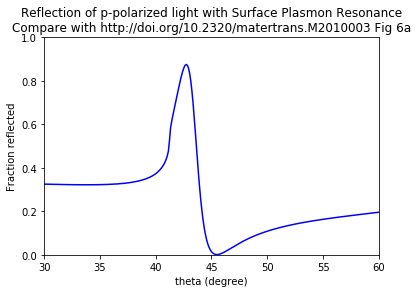

In [9]:
# list of layer thicknesses in nm
d_list = [inf, 5, 30, inf]
# list of refractive indices
n_list = [1.517, 3.719+4.362j, 0.130+3.162j, 1]
# wavelength in nm
lam_vac = 633
# list of angles to plot
theta_list = linspace(30*degree, 60*degree, num=300)
# initialize lists of y-values to plot
Rp = []
for theta in theta_list:
    Rp.append(coh_tmm('p', n_list, d_list, theta, lam_vac)['R'])
plt.figure()
plt.plot(theta_list/degree, Rp, 'blue')
plt.xlabel('theta (degree)')
plt.ylabel('Fraction reflected')
plt.xlim(30, 60)
plt.ylim(0, 1)
plt.title('Reflection of p-polarized light with Surface Plasmon Resonance\n'
          'Compare with http://doi.org/10.2320/matertrans.M2010003 Fig 6a');